<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Final_1D_CNN_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
#file_path = "/content/drive/MyDrive/2025/Honours Project/Datasets/cicids2017_cleaned.csv"
#file_path = "/content/drive/MyDrive/Honours Project/Datasets/ADASYN_CICIDS2017_Dataset.csv" # for Claire
# file_path = "/content/drive/MyDrive/Honours Project/Datasets/CICIDS2017 ADASYN Dataset/ADASYN_CICIDS2017_Dataset.csv" #For Chris
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Use the specified mapping

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


# Train/val/test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of data split

Input Shapes -> Train: (1613280, 52), Val: (403320, 52), Test: (504151, 52)
Labels distribution -> Train: [1340836   58044    1371    5856   81929    1247  123997], Val: [335209  14511    343   1464  20482    312  30999], Test: [419012  18139    429   1830  25603    389  38749]


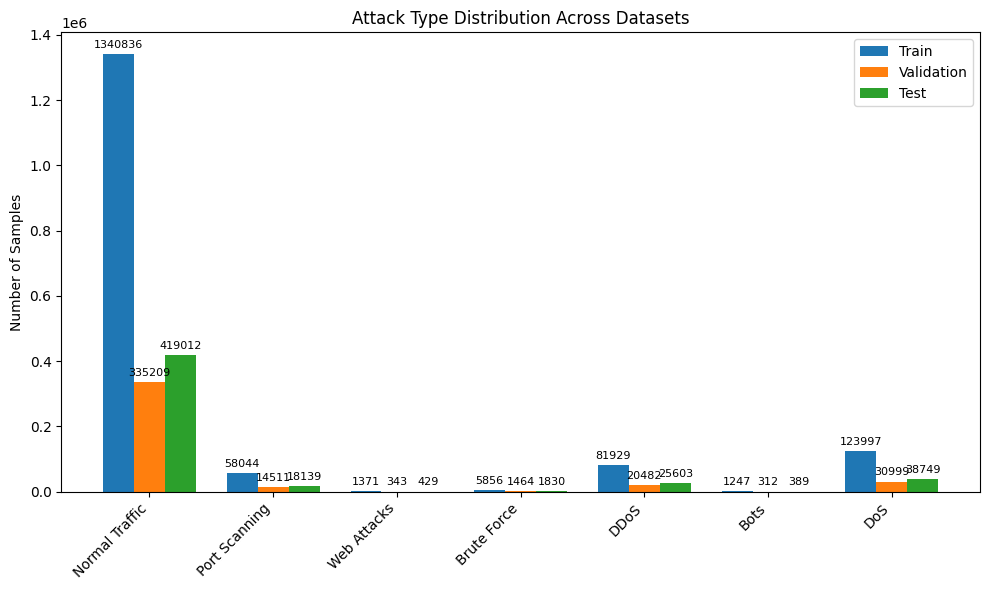

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

#Normalise the datasets

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

Shape of X_train after scaling: (1613280, 52)
Shape of X_val after scaling: (403320, 52)
Shape of X_test after scaling: (504151, 52)


#Save Datasets

In [ ]:
import numpy as np
import os
import pandas as pd

# Define the directory path
save_dir = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Baseline CNN Models/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Convert numpy arrays back to pandas DataFrames
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])) # Reshape back to 2D
X_val_df = pd.DataFrame(X_val.reshape(X_val.shape[0], X_val.shape[1]))
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]))

y_train_df = pd.DataFrame(y_train, columns=['Attack Type'])
y_val_df = pd.DataFrame(y_val, columns=['Attack Type'])
y_test_df = pd.DataFrame(y_test, columns=['Attack Type'])

# Concatenate X and y for each dataset
train_df = pd.concat([X_train_df, y_train_df], axis=1)
val_df = pd.concat([X_val_df, y_val_df], axis=1)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

# Save the combined datasets as CSV files
train_df.to_csv(os.path.join(save_dir, 'Baseline_train.csv'), index=False)
val_df.to_csv(os.path.join(save_dir, 'Baseline_validate.csv'), index=False)
test_df.to_csv(os.path.join(save_dir, 'Baseline_test.csv'), index=False)


print(f"Datasets saved to {save_dir} as CSV files")

Datasets saved to /content/drive/MyDrive/Colab Notebooks/Honours Project/Baseline CNN Models/ as CSV files


# Data reshaping for 1D CNN input

In [ ]:
import numpy as np

# Reshape the data for 1D CNN input
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1613280, 52, 1)
Validation input shape: (403320, 52, 1)
Test input shape: (504151, 52, 1)


# Perform Hyperparameter Tuning (Bayesian Optimisation) of 2 layer CNN model

In [ ]:
# # Install tuner
# !pip install keras-tuner --quiet

In [ ]:
# # Setup
# import keras_tuner as kt
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras import regularizers

In [ ]:
# def build_base_model(hp):
#     model = Sequential()

#     # First Conv1D block
#     model.add(Conv1D(
#         filters=hp.Choice('conv1_filters', values=[8, 16, 32, 64, 128]),
#         kernel_size=hp.Choice('conv1_kernel_size', values=[2, 3, 5]),
#         activation='relu',
#         input_shape=(52, 1) # Define input shape here
#     ))

#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(2))
#     model.add(Dropout(hp.Choice('dropout1_rate', [0.0,0.2, 0.25, 0.3, 0.5])))

#     # Second Conv1D block
#     model.add(Conv1D(
#         filters=hp.Choice('conv2_filters', values=[8,16, 32, 64, 128]),
#         kernel_size=hp.Choice('conv2_kernel_size', values=[2, 3, 5]),
#         activation='relu'
#     ))
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(2))

#     # Flatten previous layers
#     model.add(Flatten())

#     # Dense layer with L2 regularization
#     model.add(Dense(
#         hp.Choice('dense_units', [8, 12, 24, 64]),
#         activation='relu',
#         kernel_regularizer=regularizers.l2(hp.Choice('dense_L2', [0.0, 0.001, 0.0001, 0.01]))
#     ))

#     # Dropout layer
#     model.add(Dropout(hp.Choice('dropout2_rate', [0.0, 0.2, 0.25, 0.3, 0.5])))

#     # Dense layer for multiclass classification with softmax activation
#     model.add(Dense(7, activation='softmax')) # Assuming 7 classes based on the value_counts output

#     # Compile
#     model.compile(
#         optimizer= tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])), #'adam', #add optimiser choices?
#         loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
#         metrics=['accuracy']
#     )
#     return model

In [ ]:
# # --- Create tuner ---
# tuner = kt.BayesianOptimization(
#     build_base_model,
#     objective= 'val_accuracy',#kt.Objective('val_f1_score', direction='max'),# Find the hyperparameters that give the highest possible F1 score on the validation set
#     max_trials=10,
#     directory='bayesian_tuning',
#     project_name='baseline_cnn'
# )

# # --- Implement callback ---
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
#                                patience=3, #the number of epochs to wait for an improvement
#                                restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# # --- Start tuning ---
# tuner.search(X_train, y_train,
#              epochs=10,
#              batch_size=64,
#              validation_data=(X_val, y_val),
#              callbacks=[early_stop])

In [ ]:
# # --- Display Best Variables ---
# best_hps = tuner.get_best_hyperparameters(1)[0]
# print("Best Hyperparameters:")
# for param in best_hps.values:
#     print(f"{param}: {best_hps.get(param)}")

In [ ]:
# # --- Visulise tunning results ---
# import pandas as pd
# import matplotlib.pyplot as plt

# trials = tuner.oracle.get_best_trials(num_trials=20)
# val_accuracies = [t.metrics.get_last_value('val_accuracy') for t in trials]

# plt.plot(val_accuracies, marker='o')
# plt.title('Validation Accuracy per Trial')
# plt.xlabel('Trial')
# plt.ylabel('Val Accuracy')
# plt.grid(True)
# plt.show()

#1D CNN model

In [ ]:
# #%pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# # Define the 1D CNN Model
# # Best Hyperparameters:
# # conv1_filters: 32
# # conv1_kernel_size: 2
# # dropout1_rate: 0.0
# # conv2_filters: 16
# # conv2_kernel_size: 3
# # dense_units: 64
# # dense_L2: 0.0
# # dropout2_rate: 0.5
# # learning_rate: 0.005

# # Define input shape
# input_shape = (X_train.shape[1], 1)  # (timesteps, features)
# num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer

# # Build model
# model = Sequential([
#     Input(shape=input_shape),

#     Conv1D(filters=32, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data
#     BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
#     MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features

#     Conv1D(filters=16, kernel_size=3, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
#     Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
#     Dropout(0.5), # Randomly drop 50% of the network's neurons to further prevent overfitting
#     Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
# ])

# # Compile
# model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels #'adam'

# # Summary
# model.summary()

#Sian's Nonsense

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the 1D CNN Model

#Trial 4 Complete [00h 12m 11s] val_accuracy: 0.9839135408401489
# Best Hyperparameters:
# conv1_filters: 64
# conv1_kernel_size: 2
# dropout1_rate: 0.3
# conv2_filters: 128
# conv2_kernel_size: 2
# dense_units: 32
# dense_L2: 0.0
# dropout2_rate: 0.2


# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)
num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=64, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(32, activation='relu'), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.2), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
])

# Compile
model.compile( optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels #'adam'

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 51, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 51, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,887 (261.28 KB)

 Trainable params: 66,503 (259.78 KB)

 Non-trainable params: 384 (1.50 KB)

#Create Graphical representation of the CNN Model

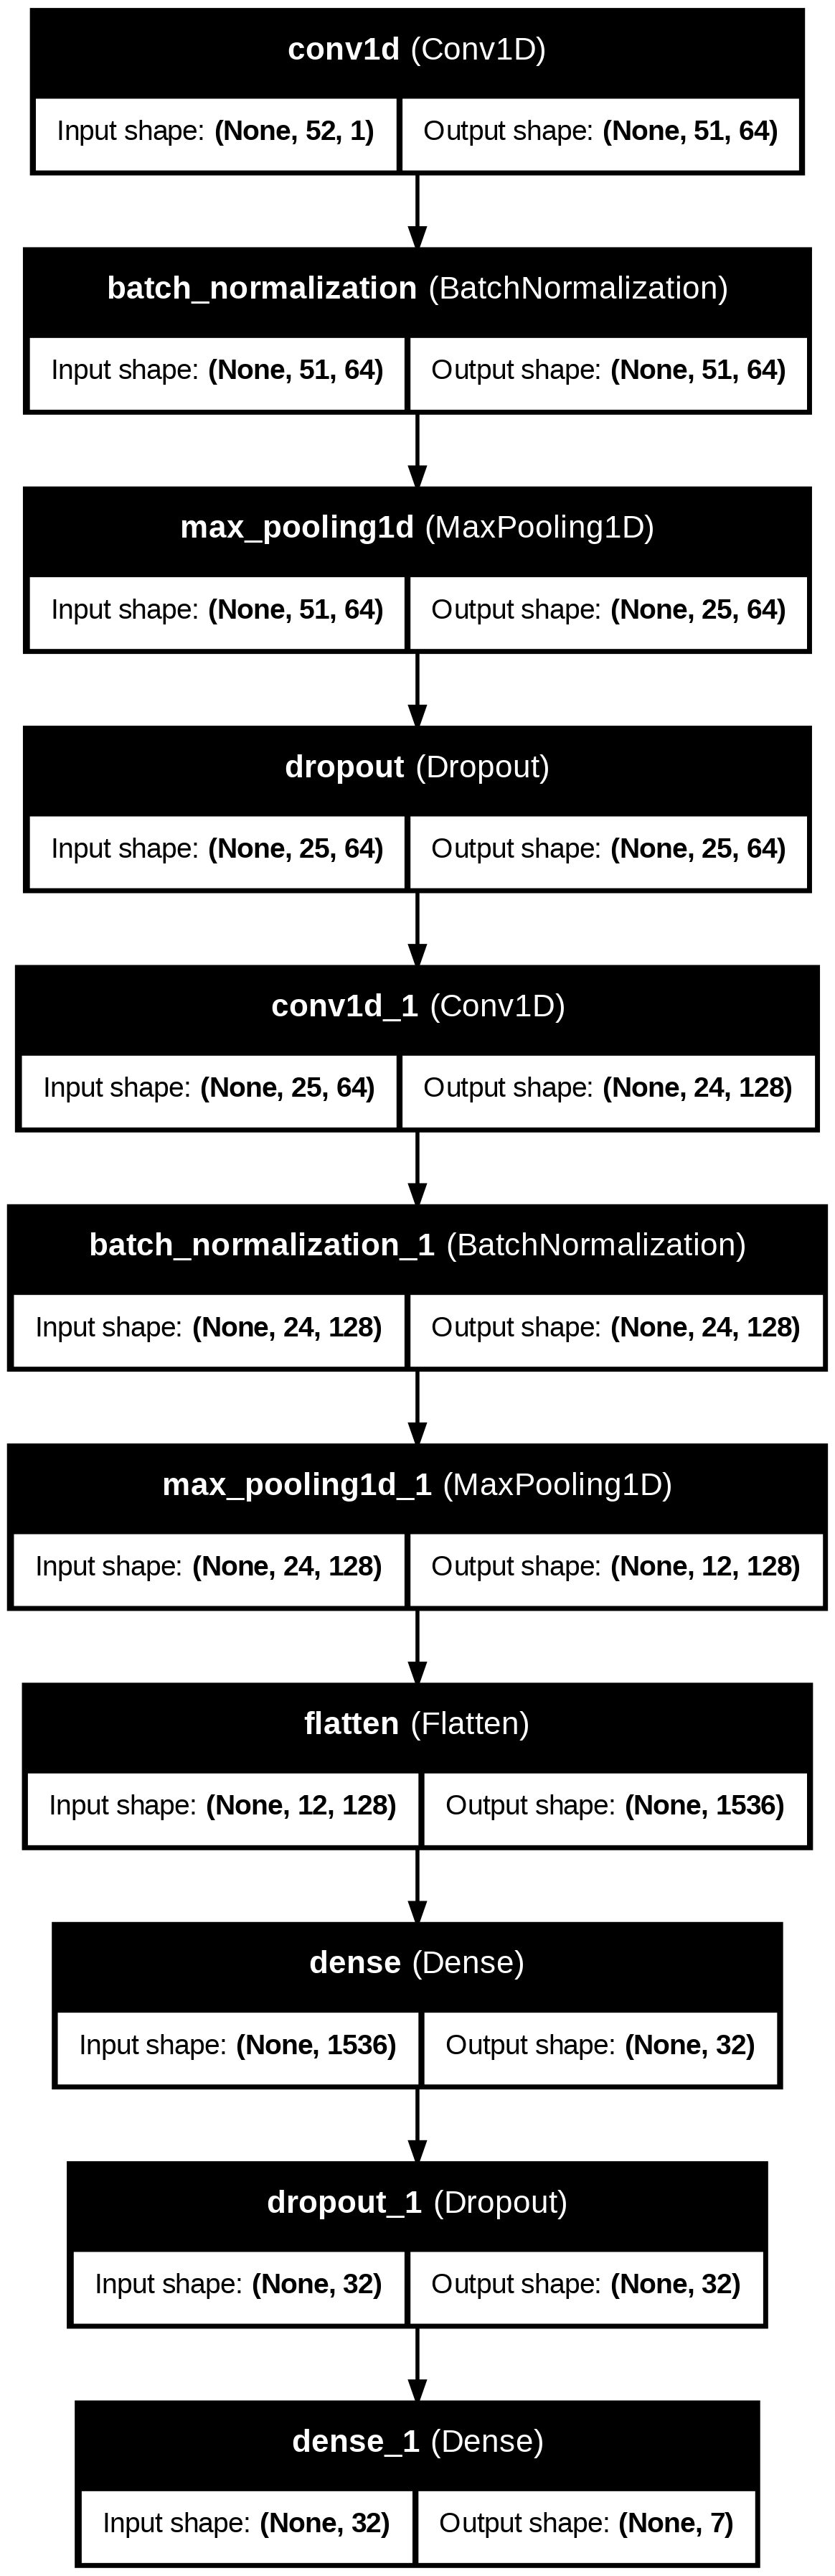

In [ ]:
from tensorflow.keras.utils import plot_model
# Create a PNG image of the model architecture

plot_model(model, to_file="baseline_model_graph.png", show_shapes=True, show_layer_names=True)
# Display it in the notebook with smaller width
Image("baseline_model_graph.png", width=400)  # width in pixels

#Train 1D CNN

- Major problems with class imbalance

Epoch 1/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - accuracy: 0.9791 - loss: 0.0483 - val_accuracy: 0.9826 - val_loss: 0.0381
Epoch 2/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.9797 - loss: 0.0460 - val_accuracy: 0.9832 - val_loss: 0.0396
Epoch 3/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - accuracy: 0.9804 - loss: 0.0438 - val_accuracy: 0.9839 - val_loss: 0.0365
Epoch 4/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - accuracy: 0.9805 - loss: 0.0435 - val_accuracy: 0.9697 - val_loss: 0.0942
Epoch 5/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 99s 4ms/step - accuracy: 0.9809 - loss: 0.0425 - val_accuracy: 0.9835 - val_loss: 0.0348
Epoch 6/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9810 - loss: 0.0420 - val_accuracy: 0.9838 - val_loss: 0.0343
Epoch 7/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 148s 4ms/step - accuracy: 0.9817 - loss: 0.0414 - val_accuracy: 0.9821 - val_loss: 0.0369
Epoch 8/10
25208/25208 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - accur

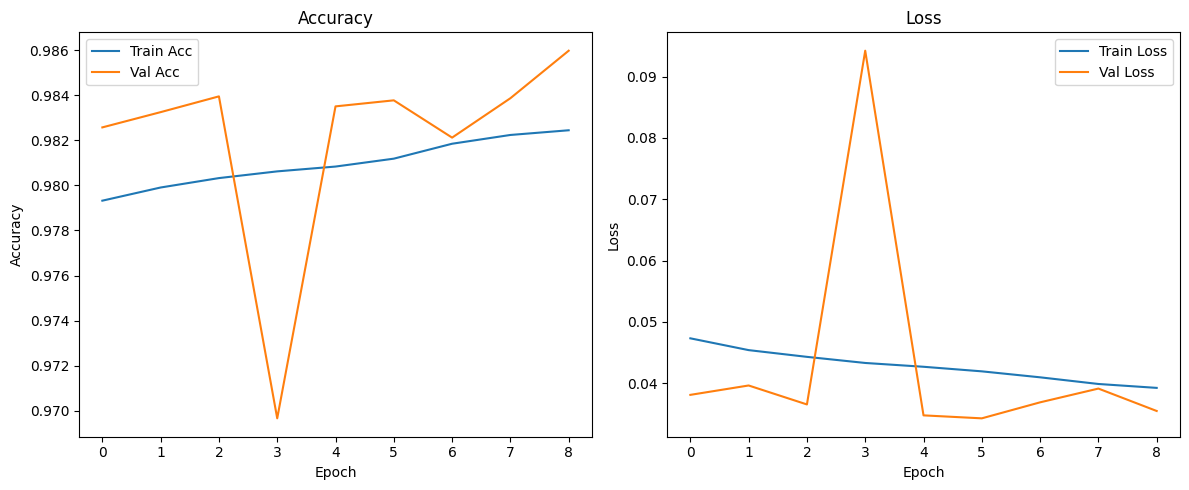

In [ ]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")


# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



#K-fold Cross Validation 1
https://media.datacamp.com/legacy/v1718738336/image_0bb32b40f1.jpg


Stratified K-fold Cross Validation

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from statistics import mean, stdev
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt

# X = cicids2017_df.drop('Attack Type', axis=1)
# y = cicids2017_df['Attack Type']

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # Define a StratifiedKFold object 'skf' that will do 5-fold cross-validation
# accuracy_scores = [] # Create a list to keep track of accuraccies

# splits = list(skf.split(X, y)) # Generate a list of the indices for each fold. Each element of the splits list is a (train_index, test_index) tuple for a fold.

# for fold in range(len(splits)): # Start folding

#     train_index, test_index = splits[fold] # Unpack the current indieces fold from splits and place them in train_index, test_index. Eg: if splits[fold] = (array([0,1,2,4]), array([3,5])) then train_index = array([0,1,2,4]) & test_index = array([3,5])

#     # Sanity check
#     print(f"Fold {fold+1}:")
#     print(f"Train_index: {train_index}")
#     print(f"Test_index: {test_index}")

# # for fold, (train_index, test_index) in enumerate(skf.split(X, y)): # Start the corss validation
# #     print(f"\n--- Fold {fold+1} ---")

#     # Split data into the training and testing folds
#     x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] # Use iloc since the dataframe is still a panda datafram
#     y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

#     # Standarise
#     x_train_fold = scaler.fit_transform(x_train_fold) # Standardise the folds according to the test fold
#     x_test_fold = scaler.transform(x_test_fold)

#     # Shape for data for CNN Input
#     x_train_fold = x_train_fold.reshape((x_train_fold.shape[0], x_train_fold.shape[1], 1))
#     x_test_fold = x_test_fold.reshape((x_test_fold.shape[0], x_test_fold.shape[1], 1))

#     input_shape = (x_train_fold.shape[1], 1)
#     num_classes = len(attack_type_map)

#     print(f"Input shape: {input_shape}")
#     print(f"Number of classes: {num_classes}")

#     # Define the Baseline CNN model
#     baseline_model = Sequential([
#       Input(shape=input_shape),

#       Conv1D(filters=32, kernel_size=2, activation='relu'),
#       BatchNormalization(),
#       MaxPooling1D(pool_size=2),

#       Conv1D(filters=16, kernel_size=3, activation='relu'),
#       BatchNormalization(),
#       MaxPooling1D(pool_size=2),

#       Flatten(),
#       Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)),
#       Dropout(0.5),
#       Dense(num_classes, activation='softmax')
#     ])

#     baseline_model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     # Early stopping
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     # Train the baseline model
#     history = baseline_model.fit(
#         x_train_fold, y_train_fold,
#         epochs=10,
#         batch_size=64,
#         #validation_data=(x_test_fold, y_test_fold),
#         callbacks=[early_stopping],
#         verbose=0
#     )

#     # Evaluate the baseline model
#     loss, acc = model.evaluate(x_test_fold, y_test_fold, verbose=0)
#     print(f"Fold {fold+1} Accuracy: {acc:.4f}")
#     accuracy_scores.append(acc)


# # Final results
# print('\nList of accuracy scores:', accuracy_scores)
# print('Maximum Accuracy: {:.2f}%'.format(max(accuracy_scores) * 100))
# print('Minimum Accuracy: {:.2f}%'.format(min(accuracy_scores) * 100))
# print('Mean Accuracy: {:.2f}%'.format(mean(accuracy_scores) * 100))
# print('Standard Deviation: {:.4f}'.format(stdev(accuracy_scores)))

Fold 1:
Train_index: [      0       1       2 ... 2520747 2520748 2520749]
Test_index: [     10      23      25 ... 2520742 2520743 2520750]
Input shape: (52, 1)
Number of classes: 7


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


KeyboardInterrupt: 

# K-Fold Cross Validation 2

Imports

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from statistics import mean, stdev
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
# from sklearn.utils.class_weight import compute_class_weight



Define model creation

In [ ]:
# def create_cnn_model(input_shape, num_classes):
#     model = Sequential([
#         Input(shape=input_shape),
#         Conv1D(filters=32, kernel_size=2, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.0),
#         Conv1D(filters=16, kernel_size=3, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Flatten(),
#         Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

Cross validation loop

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import numpy as np

# X = cicids2017_df.drop('Attack Type', axis=1).values
# y = cicids2017_df['Attack Type'].values

# # Calculate weights from the original label vector
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y),
#     y=y
# )
# class_weight_dict = dict(enumerate(class_weights))

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold = 1
# results = []

# for train_index, test_index in skf.split(X, y):
#     print(f"\nFold {fold}")

#     X_train_fold, X_test_fold = X[train_index], X[test_index]
#     y_train_fold, y_test_fold = y[train_index], y[test_index]

#     # Scaling
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_fold)
#     X_test_scaled = scaler.transform(X_test_fold)

#     # Reshape for 1D CNN
#     X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
#     X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

#     # Build model
#     model = create_cnn_model(input_shape=(X_train_scaled.shape[1], 1), num_classes=len(attack_type_map))

#     # Early stopping
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     # Train
#     history = model.fit(X_train_scaled, y_train_fold,
#                         validation_split=0.1,
#                         epochs=10,
#                         batch_size=64,
#                         callbacks=[early_stopping],
#                         class_weight=class_weight_dict,
#                         verbose=0)

#     # Predict & evaluate
#     y_pred_probs = model.predict(X_test_scaled)
#     y_pred = np.argmax(y_pred_probs, axis=1)

#     acc = accuracy_score(y_test_fold, y_pred)
#     print(f"Fold {fold} Accuracy: {acc:.4f}")
#     missing_preds = np.setdiff1d(np.unique(y_test_fold), np.unique(y_pred))
#     print(f"Classes not predicted in Fold {fold}: {missing_preds}")
#     results.append({
#         'fold': fold,
#         'accuracy': acc,
#         'report': classification_report(y_test_fold, y_pred, output_dict=True),
#         'confusion_matrix': confusion_matrix(y_test_fold, y_pred)
#     })

#     fold += 1

Summarise results

In [ ]:
# import seaborn as sns

# # Average accuracy
# avg_acc = np.mean([r['accuracy'] for r in results])
# print(f"\nAverage Accuracy over 5 folds: {avg_acc:.4f}")

# # Summary of results
# for r in results:
#     fold = r['fold']
#     acc = r['accuracy']
#     f1 = r['report']['macro avg']['f1-score']
#     print(f"Fold {fold}: Accuracy = {acc:.4f}, Macro F1 = {f1:.4f}")

# # Print missing classes
# reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}

# for r in results:
#     fold = r['fold']
#     cm = r['confusion_matrix']
#     pred_totals = cm.sum(axis=0)

#     missing_classes = [i for i, val in enumerate(pred_totals) if val == 0]
#     missing_class_names = [reverse_attack_type_map[i] for i in missing_classes]

#     if missing_class_names:
#         print(f"Fold {fold} missed predicting classes: {missing_class_names}")

# for r in results:
#     fold = r['fold']
#     cm = r['confusion_matrix']

#     # Plot the heatmap
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=[reverse_attack_type_map[i] for i in range(cm.shape[0])],
#                 yticklabels=[reverse_attack_type_map[i] for i in range(cm.shape[0])])
#     plt.title(f"Fold {fold} Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.tight_layout()
#     plt.show()

# # Plot accuracy across all folds
# folds = [r['fold'] for r in results]
# accuracies = [r['accuracy'] for r in results]

# plt.plot(folds, accuracies, marker='o')
# plt.title("Accuracy Across Folds")
# plt.xlabel("Fold")
# plt.ylabel("Accuracy")
# plt.grid(True)
# plt.show()

# Evaluate 1D CNN Malware Detection Results

15755/15755 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step

Confusion Matrix:


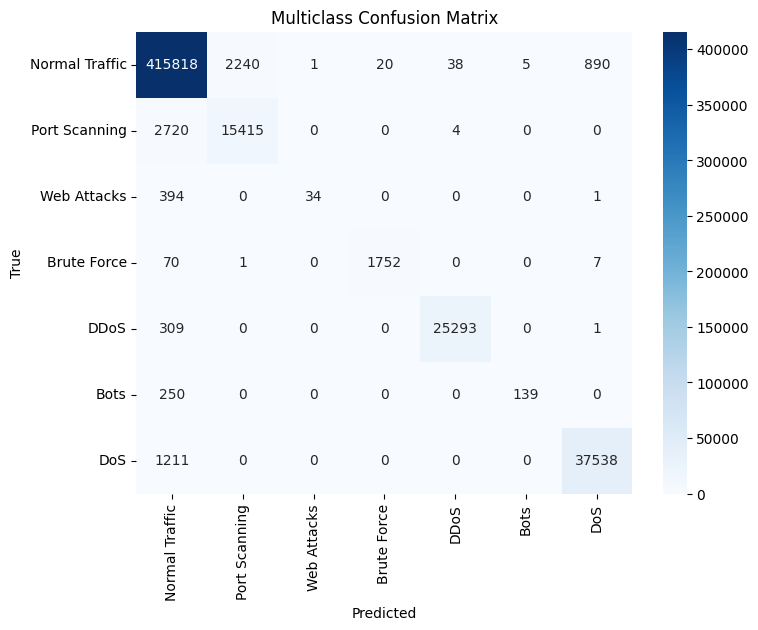


Accuracy:
sklearn Accuracy: 0.9838104060093107
Shape of X_test before model.evaluate: (504151, 52, 1)
model.evaluate Accuracy: 0.9838

Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.99      0.99      0.99    419012
 Port Scanning       0.87      0.85      0.86     18139
   Web Attacks       0.97      0.08      0.15       429
   Brute Force       0.99      0.96      0.97      1830
          DDoS       1.00      0.99      0.99     25603
          Bots       0.97      0.36      0.52       389
           DoS       0.98      0.97      0.97     38749

      accuracy                           0.98    504151
     macro avg       0.97      0.74      0.78    504151
  weighted avg       0.98      0.98      0.98    504151

Total Malware Samples: 85139
Malware Identified (True Positives): 80171
Percentage of Malware Identified: 94.16%
Total Benign Samples: 419012
Benign Misclassified as Malware (False Positives): 3194
Percentage of Benign Mis

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for plotting
import tensorflow as tf # Import tensorflow

# Get models predictions of x_test dataset
y_pred_probs = model.predict(X_test)

# For multiclass classification, the prediction is the class with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Confusion matrix ---
# For multiclass, confusion_matrix directly handles the true and predicted labels
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")

# --- Heatmap ---
# Get the original attack type names from the mapping
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])] # Use matrix shape for label count

# Plot heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))

# --- Debugging step: Print the shape of X_test ---
print(f"Shape of X_test before model.evaluate: {X_test.shape}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_test, y_pred, target_names=labels))

# --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
normal_traffic_label = attack_type_map.get('Normal Traffic', None)

if normal_traffic_label is not None:
    # True Positives for Malware = sum of diagonals excluding 'Normal Traffic'
    malware_identified_count = np.sum(np.diag(cm)) - cm[normal_traffic_label, normal_traffic_label]

    # Total Malware = sum of all non-'Normal Traffic' samples
    total_malware_count = np.sum(cm) - np.sum(cm[normal_traffic_label, :])

    # % of Malware Identified
    percentage_malware_identified = (malware_identified_count / total_malware_count) * 100 if total_malware_count > 0 else 0

    # False Positives = Non-'Normal' samples predicted as 'Normal'
    benign_not_identified_count = np.sum(cm[normal_traffic_label, :]) - cm[normal_traffic_label, normal_traffic_label]
    total_benign_count = np.sum(cm[normal_traffic_label, :])

    # % of Benign Traffic Misclassified
    percentage_benign_not_identified = (benign_not_identified_count / total_benign_count) * 100 if total_benign_count > 0 else 0

    print(f"Total Malware Samples: {total_malware_count}")
    print(f"Malware Identified (True Positives): {malware_identified_count}")
    print(f"Percentage of Malware Identified: {percentage_malware_identified:.2f}%")
    print(f"Total Benign Samples: {total_benign_count}")
    print(f"Benign Misclassified as Malware (False Positives): {benign_not_identified_count}")
    print(f"Percentage of Benign Misclassified: {percentage_benign_not_identified:.2f}%")

    # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
    # For binary classification (Malware vs Benign):
    # TP: Malware correctly predicted as Malware (malware_identified_count)
    # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
    # FP: Benign incorrectly predicted as Malware (benign_not_identified_count)
    # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified)

    tp = malware_identified_count
    tn = cm[normal_traffic_label, normal_traffic_label]
    fp = benign_not_identified_count
    fn = total_malware_count - malware_identified_count

    print("\nTP, TN, FP, FN for Malware vs Benign:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")

# --- Percentage of each malware class correctly identified ---
    print("\nPercentage of each Malware Class Correctly Identified:")
    for i, label in enumerate(labels):
        if i != normal_traffic_label: # Exclude 'Normal Traffic'
            correctly_identified = cm[i, i]
            total_in_class = np.sum(cm[i, :])
            percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
            print(f"{label}: {percentage_identified:.2f}%")

#Save best baseline model

In [ ]:
# import pickle
# import os

# # Define the directory path
# save_dir = '/content/drive/MyDrive/Colab Notebooks/Honours Project'

# # Create the directory if it doesn't exist
# os.makedirs(save_dir, exist_ok=True)

# # Save the trained model
# model_path = os.path.join(save_dir, 'Best_Baseline.keras')
# model.save(model_path)  # Native Keras format
# print(f"Model saved as {model_path}")


In [ ]:
# --- For Sian's Nonsense

In [ ]:
import pickle
import os

# Define the directory path
save_dir = '/content/drive/MyDrive/Colab Notebooks/Honours Project'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(save_dir, 'Best_Baseline2.keras')
model.save(model_path)  # Native Keras format
print(f"Model saved as {model_path}")

Model saved as /content/drive/MyDrive/Colab Notebooks/Honours Project/Best_Baseline2.keras


#Quantisation of Baseline model
https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4

Load in Best Baseline model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Load baseline model ---
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Honours Project/Baseline CNN Models/Best_Baseline.keras'
)
model_name_prefix = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Baseline CNN Models/Best_Baseline'

In [ ]:
model_name_prefix = "/content/drive/MyDrive/2025/Honours Project/Baseline CNN Models/Best_Baseline"

Weight-only quantisation (Dynamic Range Quantization)

In [ ]:
# --- Float32 baseline (no quantization) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
quantModel_f32 = converter.convert()

# --- Weight-only quantization (int8 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # triggers int8 weight quantization
quantModel_int8_weights = converter.convert()

# --- Weight-only quantization (float16 weights, float32 activations) ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # store weights as float16
quantModel_fp16_weights = converter.convert()

# --- Save models ---
with open(model_name_prefix + '_float32.tflite', 'wb') as f:
    f.write(quantModel_f32)

with open(model_name_prefix + '_int8_weights.tflite', 'wb') as f:
    f.write(quantModel_int8_weights)

with open(model_name_prefix + '_fp16_weights.tflite', 'wb') as f:
    f.write(quantModel_fp16_weights)


Evaluation of weight-only quant models (Dynamic Range Quantization)

In [ ]:
# --- Imports ---
import os
import psutil
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf

In [ ]:
# --- Evaluate Quant Models ---

# List of TFLite models
tflite_models = [
    {"model": quantModel_f32, "name": "Float32 Model", "filename": "_float32_optimized.tflite"}, # Added filename
    {"model": quantModel_int8_weights, "name": "Int8 Weights-Only Model", "filename": "_int8_weights.tflite"}, # Added filename
    {"model": quantModel_fp16_weights, "name": "Float16 Weights-Only Model", "filename": "_fp16_weights.tflite"} # Added filename
]

# Evaluate the models
for m in tflite_models:

    tflite_model = m["model"]
    model_name = m["name"]
    model_filename = m["filename"] # Get the filename
    print(f"\n --- Evaluating: {model_name} ---")

    # Construct the full model file path
    model_file_path = os.path.join(os.path.dirname(model_name_prefix), os.path.basename(model_name_prefix) + model_filename) # Use os.path.join to construct the path


    # Loads the TFLite model and gets it ready to make predictions
    interpreter = tf.lite.Interpreter(model_content=tflite_model) # Create interpreter object that will read and run the TFLite model
    interpreter.allocate_tensors() # Make the interpreter allocate memory
    input_details = interpreter.get_input_details() # Get expected shape and data type of the data the model needs to evaluate (built-in method)
    output_details = interpreter.get_output_details() #Sshape and data type the model will need to produce the results in

    # Start Resource Measurement
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 * 1024)  # MB
    cpu_before = psutil.cpu_percent(interval=None)
    start_time = time.time()

    # Get model predictions for test sample
    y_pred_probs = []

    for i in range(len(X_test)): # Interpreter object does not have a built-in .evaluate() method like the Keras Model object does, therefore need to go through every sample manually
        input_data = np.expand_dims(X_test[i], axis=0).astype(input_details[0]['dtype']) # Add an extra dimension to the input (model expects input in batches, even if the batch size is 1) so the data type matches what the model expects
        interpreter.set_tensor(input_details[0]['index'], input_data) #Feed a single sample of input data into the TFLite interpreter
        interpreter.invoke() # Tell the interpreter to run the model on the input data
        output_data = interpreter.get_tensor(output_details[0]['index']) # Get the output from the model
        y_pred_probs.append(output_data[0]) # Add the raw output to the list

    y_pred_probs = np.array(y_pred_probs) # Convert the list to a single NumPy array
    y_pred = np.argmax(y_pred_probs, axis=1) # Get the predicted class label for each sample

    # End Resouce Measurement
    end_time = time.time()
    mem_after = process.memory_info().rss / (1024 * 1024)
    cpu_after = psutil.cpu_percent(interval=None)

    # Calculate Resource Measurement
    storage_size_mb = os.path.getsize(model_file_path) / (1024 * 1024) # Use the correct file path
    memory_used_mb = mem_after - mem_before
    cpu_usage_percent = cpu_after - cpu_before
    inference_time_sec = end_time - start_time

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    plt.figure(figsize=(8, 4)) # Create confusion matrix plot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_label = attack_type_map.get('Normal Traffic', None)
    if normal_label is not None:
        malware_identified = np.sum(np.diag(cm)) - cm[normal_label, normal_label]
        total_malware = np.sum(cm) - np.sum(cm[normal_label, :])
        percentage_malware_identified = (malware_identified / total_malware * 100) if total_malware > 0 else 0

        benign_misclassified = np.sum(cm[normal_label, :]) - cm[normal_label, normal_label]
        total_benign = np.sum(cm[normal_label, :])
        percentage_benign_misclassified = (benign_misclassified / total_benign * 100) if total_benign > 0 else 0

        print(f"Malware Identified: {malware_identified}/{total_malware} ({percentage_malware_identified:.2f}%)")
        print(f"Benign Misclassified: {benign_misclassified}/{total_benign} ({percentage_benign_misclassified:.2f}%)")
        print(f"TP: {malware_identified}, TN: {cm[normal_label, normal_label]}, FP: {benign_misclassified}, FN: {total_malware - malware_identified}")

    # Display Resource Usage
    print(f"\n--- Resource Usage for {model_name} ---")
    print(f"Storage size: {storage_size_mb:.2f} MB")
    print(f"Memory used during inference: {memory_used_mb:.2f} MB")
    print(f"CPU usage change: {cpu_usage_percent:.2f}%")
    print(f"Inference time: {inference_time_sec:.4f} sec")

    # Add a pause to allow CPU to reset
    #time.sleep(5) # Pause for 5 seconds

Full integer Quantisation of the model

In [ ]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import numpy as np # Import numpy for representative dataset
import os

In [ ]:
# --- Representitive Dataset ---

def representative_dataset_gen(): # Using a small subset of the training data as the representative dataset for the quant models

    class_types, class_counts = np.unique(y_train, return_counts=True)# Get the number of unique classes in the training set + how many samples are of each class
    min_samples_per_class = min(class_counts)# Determine the minimum number of samples per class
    class_indices = [np.where(y_train == c)[0] for c in class_types]# Create indices for each class

    # Select an equal number of samples from each class
    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(np.random.choice(indices, min_samples_per_class, replace=False))# Pick the samples at random

    np.random.shuffle(selected_indices)# Shuffle the indices, therefore shuffling the data

    num_samples_to_yield = len(selected_indices) # Use a reasonable number of samples
    representative_indices = selected_indices[:num_samples_to_yield]

    # Display the class distribution of the representative dataset
    representative_labels = [y_train.iloc[i] for i in representative_indices] # Collect labels to display distribution
    unique_labels, counts = np.unique(representative_labels, return_counts=True)
    print("\nRepresentative Dataset Class Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Class {label}: {count} samples")

    for i in representative_indices:
        # Yield the sample in the format expected by the converter
        yield [np.expand_dims(X_train[i].astype(np.float32), axis=0)]

In [ ]:
# --- Full Integer Model Quantization ---

# Create a float32 optimized model (no quantization, just optimization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations
converter.target_spec.supported_types = [tf.float32] # Specify target data type
quantModel_f32 = converter.convert() # Convert the model

# Create an int8 quantized model (requires representative dataset)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations
converter.target_spec.supported_types = [tf.int8] # Specify target data type as int8
converter.representative_dataset = representative_dataset_gen # Provide the representative dataset and ensure input dtype is float32
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]# Specify OpsSet must specifically targets the 8-bit integer quantized versions of the TensorFlow Lite built-in operations.
# Set the input and output types to int8 for inference
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantModel_int8 = converter.convert() # Convert the model

# --- 3. Perform 16x8 Full Integer Quantization ---
# This converts weights to int8 and activations to int16.
print("\n--- Converting model to 16x8 quantized TFLite format ---")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]# Specify the experimental ops set for 16x8 quantization - int16 activations and int8 weights.
converter.inference_input_type = tf.int16
converter.inference_output_type = tf.int16
quant_int16x8_model = converter.convert()# Convert the model


# --- Save models ---
os.makedirs('models', exist_ok=True)
with open(model_name_prefix + '_float32_optimized.tflite', 'wb') as f: # Added _optimized to filename
    f.write(quantModel_f32)
with open(model_name_prefix + '_int8_full.tflite', 'wb') as f: # Added _full to filename
    f.write(quantModel_int8)
with open(model_name_prefix + '_int16x8_full.tflite', 'wb') as f: # Added _full to filename
    f.write(quant_int16x8_model)

Evaluation of quant models

In [ ]:
# -- Imports ---
import os
import psutil
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf

In [ ]:
# --- List of TFLite models ---
tflite_models = [
    {"model": quantModel_f32, "name": "Float32 Optimized Model", "filename": "_float32_optimized.tflite"}, # Added filename
    {"model": quantModel_int8, "name": "Int8 Quantized Model", "filename": "_int8_full.tflite"}, # Added filename
    {"model": quant_int16x8_model, "name": "Int16x8 Quantized Model", "filename": "_int16x8_full.tflite"} # Added filename
]

# --- Evaluate all models with metrics + resource tracking ---
for m in tflite_models:
    tflite_model = m["model"]
    model_name = m["name"]
    model_filename = m["filename"] # Get the filename
    print(f"\n=== Evaluating: {model_name} ===")

    # Construct the full model file path for resource measurement
    model_file = model_name_prefix + model_filename # Define model_file here

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    in_scale,  in_zp  = input_details['quantization']
    out_scale, out_zp = output_details['quantization']

    # Start Resource Measurement
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 * 1024)  # MB
    cpu_before = psutil.cpu_percent(interval=None)
    start_time = time.time()

    # Predictions
    y_pred_probs = []
    for i in range(len(X_test)):
      x = np.expand_dims(X_test[i].astype(np.float32), axis=0)

      # Quantize input correctly for int8 models
      if input_details['dtype'] == np.int8:
          xq = np.round(x / in_scale + in_zp).astype(np.int8)
      else:
          xq = x.astype(input_details['dtype'])

      interpreter.set_tensor(input_details['index'], xq)
      interpreter.invoke()
      yq = interpreter.get_tensor(output_details['index'])

      # Dequantize outputs back to float for metrics
      if output_details['dtype'] == np.int8:
          y = (yq.astype(np.float32) - out_zp) * out_scale
      else:
          y = yq.astype(np.float32)

      y_pred_probs.append(y[0])

    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # End Resouce Measurement
    end_time = time.time()
    mem_after = process.memory_info().rss / (1024 * 1024)
    cpu_after = psutil.cpu_percent(interval=None)

    # Calculate Resource Measurement
    storage_size_mb = os.path.getsize(model_file) / (1024 * 1024) # Get size of model in megabytes
    memory_used_mb = mem_after - mem_before
    cpu_usage_percent = cpu_after - cpu_before
    inference_time_sec = end_time - start_time

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Malware vs Benign metrics
    normal_label = attack_type_map.get('Normal Traffic', None)
    if normal_label is not None:
        malware_identified = np.sum(np.diag(cm)) - cm[normal_label, normal_label]
        total_malware = np.sum(cm) - np.sum(cm[normal_label, :])
        percentage_malware_identified = (malware_identified / total_malware * 100) if total_malware > 0 else 0

        benign_misclassified = np.sum(cm[normal_label, :]) - cm[normal_label, normal_label]
        total_benign = np.sum(cm[normal_label, :])
        percentage_benign_misclassified = (benign_misclassified / total_benign * 100) if total_benign > 0 else 0

        print(f"Malware Identified: {malware_identified}/{total_malware} ({percentage_malware_identified:.2f}%)")
        print(f"Benign Misclassified: {benign_misclassified}/{total_benign} ({percentage_benign_misclassified:.2f}%)")
        print(f"TP: {malware_identified}, TN: {cm[normal_label, normal_label]}, FP: {benign_misclassified}, FN: {total_malware - malware_identified}")

    # Display Resource Usage
    print(f"\n--- Resource Usage for {model_name} ---")
    print(f"Storage size: {storage_size_mb:.2f} MB")
    print(f"Memory used during inference: {memory_used_mb:.2f} MB")
    print(f"CPU usage change: {cpu_usage_percent:.2f}%")
    print(f"Inference time: {inference_time_sec:.4f} sec")

In [ ]:
# --- List of TFLite models ---
tflite_models = [
    {"model": quantModel_f32, "name": "Float32 Optimized Model", "filename": "_float32_optimized.tflite"}, # Added filename
    {"model": quantModel_int8, "name": "Int8 Quantized Model", "filename": "_int8_full.tflite"}, # Added filename
    {"model": quant_int16x8_model, "name": "Int16x8 Quantized Model", "filename": "_int16x8_full.tflite"} # Added filename
]

# --- Evaluate all models with metrics + resource tracking ---
for m in tflite_models:
    tflite_model = m["model"]
    model_name = m["name"]
    model_filename = m["filename"] # Get the filename
    print(f"\n=== Evaluating: {model_name} ===")

    # Construct the full model file path for resource measurement
    model_file = model_name_prefix + model_filename # Define model_file here

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Start Resource Measurement
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 * 1024)  # MB
    cpu_before = psutil.cpu_percent(interval=None)
    start_time = time.time()

    # Predictions
    y_pred_probs = []
    for i in range(len(X_test)):
        input_data = np.expand_dims(X_test[i], axis=0).astype(input_details[0]['dtype'])
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_probs.append(output_data[0])

    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # End Resouce Measurement
    end_time = time.time()
    mem_after = process.memory_info().rss / (1024 * 1024)
    cpu_after = psutil.cpu_percent(interval=None)

    # Calculate Resource Measurement
    storage_size_mb = os.path.getsize(model_file) / (1024 * 1024) # Get size of model in megabytes
    memory_used_mb = mem_after - mem_before
    cpu_usage_percent = cpu_after - cpu_before
    inference_time_sec = end_time - start_time

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Malware vs Benign metrics
    normal_label = attack_type_map.get('Normal Traffic', None)
    if normal_label is not None:
        malware_identified = np.sum(np.diag(cm)) - cm[normal_label, normal_label]
        total_malware = np.sum(cm) - np.sum(cm[normal_label, :])
        percentage_malware_identified = (malware_identified / total_malware * 100) if total_malware > 0 else 0

        benign_misclassified = np.sum(cm[normal_label, :]) - cm[normal_label, normal_label]
        total_benign = np.sum(cm[normal_label, :])
        percentage_benign_misclassified = (benign_misclassified / total_benign * 100) if total_benign > 0 else 0

        print(f"Malware Identified: {malware_identified}/{total_malware} ({percentage_malware_identified:.2f}%)")
        print(f"Benign Misclassified: {benign_misclassified}/{total_benign} ({percentage_benign_misclassified:.2f}%)")
        print(f"TP: {malware_identified}, TN: {cm[normal_label, normal_label]}, FP: {benign_misclassified}, FN: {total_malware - malware_identified}")

    # Display Resource Usage
    print(f"\n--- Resource Usage for {model_name} ---")
    print(f"Storage size: {storage_size_mb:.2f} MB")
    print(f"Memory used during inference: {memory_used_mb:.2f} MB")
    print(f"CPU usage change: {cpu_usage_percent:.2f}%")
    print(f"Inference time: {inference_time_sec:.4f} sec")